In [17]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 
import os
import pickle
from PIL import Image

In [19]:
def segment_image(image, grid_size):
    """Segments the image into grid_size x grid_size pieces."""
    img_width, img_height = image.size
    piece_width = img_width // grid_size
    piece_height = img_height // grid_size
    
    pieces = []
    for i in range(grid_size):
        for j in range(grid_size):
            left = j * piece_width
            upper = i * piece_height
            right = (j + 1) * piece_width
            lower = (i + 1) * piece_height
            piece = image.crop((left, upper, right, lower))
            pieces.append(piece)
     
    return pieces

In [20]:
def display_images(correct_images, puzzle_images):
    """Displays correct and puzzle images side by side."""
    num_images = len(correct_images)
    plt.figure(figsize=(12, num_images * 6))
    
    for i in range(num_images):
        # Display correct image
        plt.subplot(num_images, 2, 2*i + 1)
        plt.imshow(correct_images[i])
        plt.title(f'Correct Image {i+1}')
        plt.axis('off')
        
        # Display puzzle image
        plt.subplot(num_images, 2, 2*i + 2)
        plt.imshow(puzzle_images[i])
        plt.title(f'Puzzle Image {i+1}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

In [21]:
def display_pieces(pieces, grid_size):
    """Displays segmented pieces in a grid."""
    num_pieces = len(pieces)
    plt.figure(figsize=(grid_size * 3, grid_size * 3))
    
    for i in range(num_pieces):
        plt.subplot(grid_size, grid_size, i + 1)
        plt.imshow(pieces[i])
        plt.title(f'Piece {i+1}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

In [22]:
def apply_bileteral_filter(image, d=9, sigmaColor=75, sigmaSpace=75):
    """Applies bilateral filter to the image."""
    img_array = np.array(image)
    filtered_img = cv2.bilateralFilter(img_array, d, sigmaColor, sigmaSpace)

    return Image.fromarray(filtered_img)

In [23]:
def apply_canny_edge_detection(image, low_threshold=100, high_threshold=200):
    """Applies Canny edge detection to the input image."""
    gray_image = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(gray_image, low_threshold, high_threshold)
    return edges

In [26]:
def extract_edge_regions(edge_image, edge_width=5):
    """
    Extract the 4 border regions from an edge-detected image.
    These are the regions we'll compare for matching.
    """
    h, w = edge_image.shape
    
    edges = {
        'top': edge_image[:edge_width, :],           # First N rows
        'bottom': edge_image[-edge_width:, :],       # Last N rows
        'left': edge_image[:, :edge_width],          # First N columns
        'right': edge_image[:, -edge_width:]         # Last N columns
    }
    
    return edges

In [27]:
def compute_descriptors(edge_regions):
    """
    Compute multiple descriptors for each edge region.
    
    Descriptors computed:
    1. Raw pixels - for accurate matching
    2. Density profile - edge count per row/column
    3. Statistical features - for quick filtering
    4. Boundary line - pixels at the piece boundary
    5. Gradient features - direction and continuity of edges
    """
    descriptors = {}
    
    for edge_name, edge_region in edge_regions.items():
        # 1. Raw pixels (for accurate matching)
        raw_pixels = edge_region.flatten().astype(np.float32)
        
        # 2. Edge density profile
        if edge_name in ['left', 'right']:
            # count per row
            density_profile = np.sum(edge_region > 0, axis=1)
        else:
            # count per column
            density_profile = np.sum(edge_region > 0, axis=0)
        
        # 3. Statistical features (for quick filtering)
        edge_count = np.sum(edge_region > 0)
        edge_ratio = edge_count / edge_region.size
        mean_intensity = np.mean(edge_region)
        
        # 4. Boundary line
        if edge_name == 'right':
            boundary_line = edge_region[:, -1]  
        elif edge_name == 'left':
            boundary_line = edge_region[:, 0]   
        elif edge_name == 'bottom':
            boundary_line = edge_region[-1, :]  
        else:  # top
            boundary_line = edge_region[0, :]   
        
        # 5. Gradient/Continuity Features
       
        edge_float = edge_region.astype(np.float32)
        
       
        gradient_x = cv2.Sobel(edge_float, cv2.CV_32F, 1, 0, ksize=3)
        gradient_y = cv2.Sobel(edge_float, cv2.CV_32F, 0, 1, ksize=3)
        
        # Gradient magnitude and direction
        gradient_magnitude = np.sqrt(gradient_x**2 + gradient_y**2)

        
        # Gradient profile at the boundary 
        if edge_name == 'right':
            # gradient at last column shows if edges exit right
            boundary_gradient_x = gradient_x[:, -1]
            boundary_gradient_y = gradient_y[:, -1]
        elif edge_name == 'left':
            
            boundary_gradient_x = gradient_x[:, 0]
            boundary_gradient_y = gradient_y[:, 0]
        elif edge_name == 'bottom':
            #gradient at last row
            boundary_gradient_x = gradient_x[-1, :]
            boundary_gradient_y = gradient_y[-1, :]
        else: 
        # gradient at first row
            boundary_gradient_x = gradient_x[0, :]
            boundary_gradient_y = gradient_y[0, :]
        
        # Continuity score       
        if edge_name == 'right':
            continuity_score = np.sum(boundary_gradient_x > 0)
        elif edge_name == 'left':
            continuity_score = np.sum(boundary_gradient_x < 0)
        elif edge_name == 'bottom':
            continuity_score = np.sum(boundary_gradient_y > 0)
        else: 
            continuity_score = np.sum(boundary_gradient_y < 0)
        
        descriptors[edge_name] = {
            'raw_pixels': raw_pixels,
            'density_profile': density_profile,
            'boundary_line': boundary_line,
            'stats': {
                'edge_count': edge_count,
                'edge_ratio': edge_ratio,
                'mean_intensity': mean_intensity
            },
            'gradient': {
                'boundary_gradient_x': boundary_gradient_x,
                'boundary_gradient_y': boundary_gradient_y,
                'mean_magnitude': np.mean(gradient_magnitude),
                'continuity_score': continuity_score
            },
            'shape': edge_region.shape
        }
    
    return descriptors

In [28]:
def process_single_piece(piece, piece_id, edge_width=10, canny_low=90, canny_high=250):
    """
    Process a single puzzle piece through the entire pipeline.
    
    Returns a dictionary with all piece information and descriptors.
    """

    filtered_piece = apply_bileteral_filter(piece)
    
    #Canny edge detection 
    gray_image = cv2.cvtColor(np.array(filtered_piece), cv2.COLOR_RGB2GRAY)
    edge_map = cv2.Canny(gray_image, canny_low, canny_high)
    
   
    edge_regions = extract_edge_regions(edge_map, edge_width)

    descriptors = compute_descriptors(edge_regions)
    
    return {
        'id': piece_id,
        'original': piece,
        'filtered': filtered_piece,
        'edge_map': edge_map,
        'edge_regions': edge_regions,
        'descriptors': descriptors
    }


def process_puzzle(puzzle_image, grid_size, edge_width=10):
    """
    Process an entire puzzle image through the pipeline.
    
    Args:
        puzzle_image: PIL Image of the shuffled puzzle
        grid_size: 2, 4, or 8 (for 2x2, 4x4, 8x8 grids)
        edge_width: Width of edge regions to extract
    
    Returns:
        Dictionary containing all processed pieces with their descriptors
    """

    pieces = segment_image(puzzle_image, grid_size)
    

    processed_pieces = {}
    for idx, piece in enumerate(pieces):
        row = idx // grid_size
        col = idx % grid_size
        piece_id = f"piece_{row}_{col}"
        
        processed_pieces[piece_id] = process_single_piece(piece, piece_id, edge_width)
        
    return {
        'grid_size': grid_size,
        'num_pieces': len(pieces),
        'pieces': processed_pieces
    }

In [29]:
def save_descriptors(puzzle_data, filepath):
    with open(filepath, 'wb') as f:
        pickle.dump(puzzle_data, f)
    print(f"Descriptors saved to {filepath}")


def load_descriptors(filepath):
    with open(filepath, 'rb') as f:
        puzzle_data = pickle.load(f)
    print(f"Descriptors loaded from {filepath}")
    return puzzle_data

In [30]:
correct = "GravityFalls\correct"
p_2 = "GravityFalls\puzzle_2x2"
p_4 = "GravityFalls\puzzle_4x4"
p_8 = "GravityFalls\puzzle_8x8"

image_files = [f for f in os.listdir(correct) if f.endswith('.png')][:7]

correct_images = []
for img_file in image_files:
    img_path = os.path.join(correct, img_file)
    img = Image.open(img_path)
    correct_images.append(img)

# Load corresponding puzzle images
puzzle_images = []
for img_file in image_files:
    # Replace .png extension with .jpg for puzzle folder
    puzzle_file = img_file.replace('.png', '.jpg')
    img_path = os.path.join(p_2, puzzle_file)
    img = Image.open(img_path)
    puzzle_images.append(img)

print(f"Loaded {len(correct_images)} correct images and {len(puzzle_images)} puzzle images")

Loaded 7 correct images and 7 puzzle images


Applying bilateral filter to piece...
Applying bilateral filter to piece...
Applying bilateral filter to piece...
Applying bilateral filter to piece...
Applying Canny edge detection to filtered piece...
Applying Canny edge detection to filtered piece...
Applying Canny edge detection to filtered piece...
Applying Canny edge detection to filtered piece...


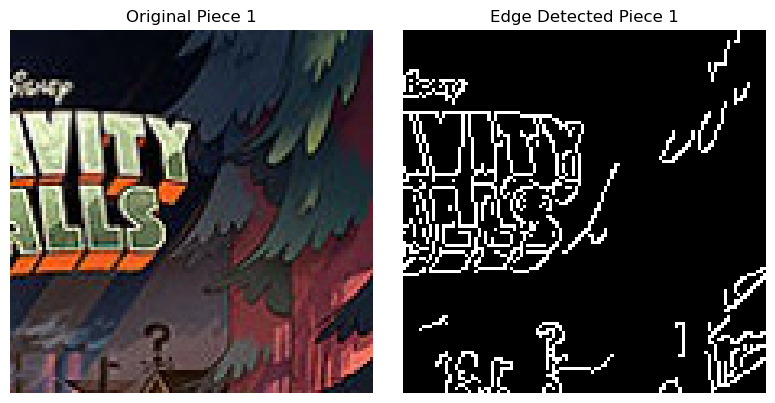

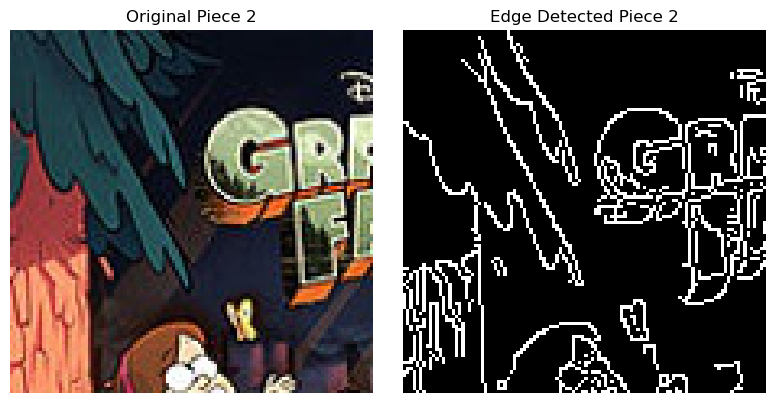

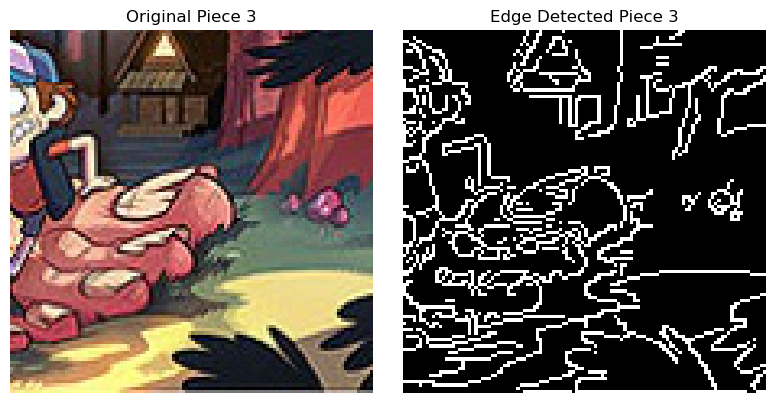

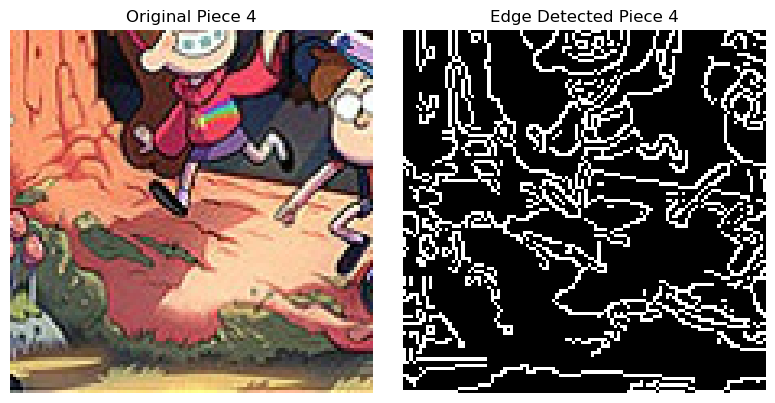

In [31]:
pieces = segment_image(puzzle_images[0], 2)
filterd_pieces = []
for piece in pieces:
    print("Applying bilateral filter to piece...")
    filtered_piece = apply_bileteral_filter(piece)
    filterd_pieces.append(filtered_piece)

pieces_uncanny = []
for piece in filterd_pieces:
    print("Applying Canny edge detection to filtered piece...")
    edges = apply_canny_edge_detection(piece,90,250)
    pieces_uncanny.append(edges)    

#let's diaply each peice's before and after side by side
for i in range(len(pieces)):
    plt.figure(figsize=(8, 4))
    
    # Original piece
    plt.subplot(1, 2, 1)
    plt.imshow(pieces[i])
    plt.title(f'Original Piece {i+1}')
    plt.axis('off')
    
    # Edge-detected piece
    plt.subplot(1, 2, 2)
    plt.imshow(pieces_uncanny[i], cmap='gray')
    plt.title(f'Edge Detected Piece {i+1}')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    